# PCA with AdaBoost Modeling

In [9]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import warnings
import time

import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SequentialFeatureSelector

# Metrics
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
# Options
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Dimensionality Reduction

In [3]:
# Read in train/test
trainDf = pd.read_csv('../data/open-fema/FEMA-Large-Demographics-FL-TX.csv')
testDf = pd.read_csv('../data/open-fema/FEMA-Large-Demographics-PR.csv')

# Combine train-test
df = pd.concat([trainDf, testDf])

There are 4599003 records in the dataframe.


In [33]:
# Define columns
cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
        'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
        'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
        'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
        'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
        'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
        'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
        'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
        'residenceType_Travel Trailer' ,'residenceType_Unknown', 'below_poverty_rate', 'median_earnings_total',
        'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate', 'dvi']

In [34]:
# Create train/test
trainDf = df.loc[df['damagedStateAbbreviation'] != 'PR', cols]
testDf = df.loc[df['damagedStateAbbreviation'] == 'PR', cols]

# Convert numpy arrays
X_train = np.array(trainDf.loc[:, trainDf.columns != 'haAmount'])
y_train = np.array(trainDf.loc[:, 'haAmount'])

X_test = np.array(testDf.loc[:, testDf.columns != 'haAmount'])
y_test = np.array(testDf.loc[:, 'haAmount'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3533663, 40) (3533663,)
(1065340, 40) (1065340,)


### Principal Components Analysis

In [35]:
def pca_plots(data, color):

    n_components = np.arange(1,7)
    individuals = []
    cumulatives = []

    # Fit Principal Component Analysis (PCA) 
    pca = PCA(n_components=6)
    pca.fit(data)

    # Cumulative sum of variance explained for each n_compoents
    for i, n in enumerate(n_components):
        individuals.append(pca.explained_variance_ratio_[i])
        cumulative = np.sum(pca.explained_variance_ratio_[:n])
        cumulatives.append(cumulative)
        print('#{}: {:.5f}'.format(n, pca.explained_variance_ratio_[i]))

    # Plot explained variance by individual component
    fig, axes = plt.subplots(1,2, figsize = (14,4))

    axes[0].bar(n_components, individuals, color=color)
    axes[0].set_title('Explained Variance by N Principal Components')
    axes[0].set_ylabel('Explained variance ratio')
    axes[0].set_xlabel('Principal components')

    # Plot cumulative explained variance
    axes[1].plot(n_components, cumulatives, color=color)
    axes[1].set_title('Cumulative Explained Variance by N Components')
    axes[1].set_ylabel('Explained variance ratio')
    axes[1].set_xlabel('Principal components')

#1: 0.89909
#2: 0.10091
#3: 0.00000
#4: 0.00000
#5: 0.00000
#6: 0.00000


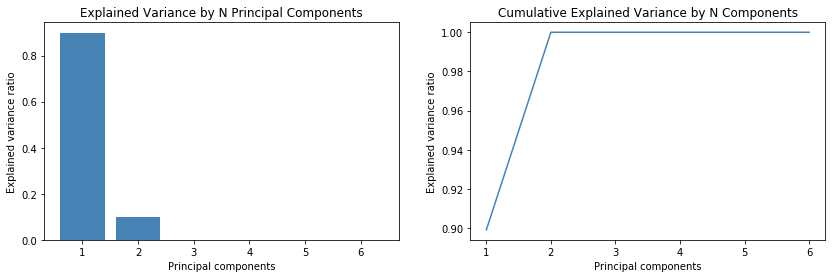

In [36]:
# Train plots
pca_plots(X_train, color = 'steelblue')

#1: 0.81600
#2: 0.18400
#3: 0.00000
#4: 0.00000
#5: 0.00000
#6: 0.00000


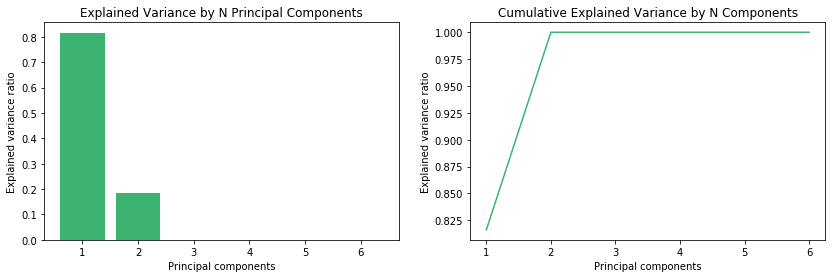

In [37]:
# Combine train/test to check for shift
X_full = np.concatenate((X_train, X_test), axis=0)

# Full plots
pca_plots(X_full, color = 'mediumseagreen')

### Full Data - Covariate Shift Check

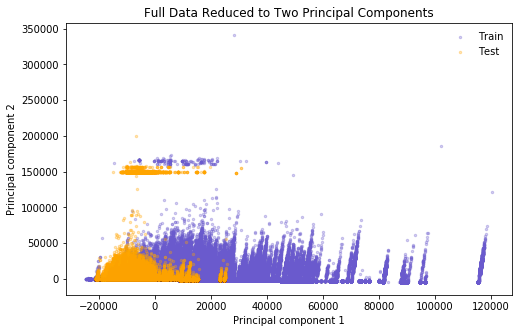

In [38]:
def reduced_dim_plot():

    # PCA full data - 2-dims
    pca = PCA(n_components=2)
    full_pca = pca.fit_transform(X_full)

    # Length for split
    cut = np.shape(X_train)[0]

    # Split full PCA into train-test
    train_pca = full_pca[:cut]
    test_pca = full_pca[cut:]

    # Plot train-test types
    fig, ax = plt.subplots(figsize = (8,5))
    plt.scatter(train_pca[:,0], train_pca[:,1], color='slateblue', s=6, alpha=0.3, label='Train')
    plt.scatter(test_pca[:,0], test_pca[:,1], color='orange', s=6, alpha=0.3, label='Test')

    ax.set_title('Full Data Reduced to Two Principal Components')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.legend(loc='upper right', frameon=False)
    
reduced_dim_plot()

### Florida-Texas - Covariate Check

In [39]:
# Create train/test
trainFlDf = trainDf.loc[df['damagedStateAbbreviation'] == 'FL', cols]
testTxDf = trainDf.loc[df['damagedStateAbbreviation'] == 'TX', cols]

# Convert numpy arrays
X_trainFl = np.array(trainFlDf.loc[:, trainFlDf.columns != 'haAmount'])
y_trainFl = np.array(trainFlDf.loc[:, 'haAmount'])

X_testTx = np.array(testTxDf.loc[:, testTxDf.columns != 'haAmount'])
y_testTx = np.array(testTxDf.loc[:, 'haAmount'])

# Combine FL/TX to check for shift
X_full_FlTx = np.concatenate((X_trainFl, X_testTx), axis=0)

print(X_trainFl.shape, y_trainFl.shape)
print(X_testTx.shape, y_testTx.shape)

(2639073, 40) (2639073,)
(894590, 40) (894590,)


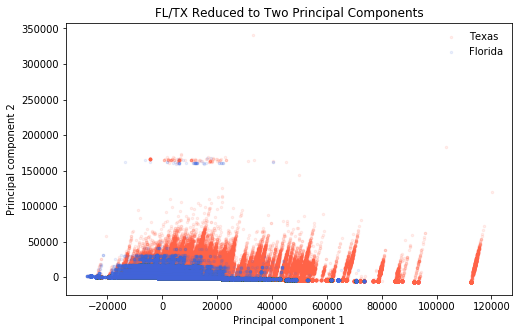

In [40]:
def reduced_FL_TX_plot():

    # PCA full data - 2-dims
    pca = PCA(n_components=2)
    full_pca = pca.fit_transform(X_full_FlTx)

    # Length for split
    cut = np.shape(X_trainFl)[0]

    # Split full PCA into train-test
    train_pca = full_pca[:cut]
    test_pca = full_pca[cut:]

    # Plot train-test types
    fig, ax = plt.subplots(figsize = (8,5))
    plt.scatter(test_pca[:,0], test_pca[:,1], color='tomato', s=6, alpha=0.1, label='Texas')
    plt.scatter(train_pca[:,0], train_pca[:,1], color='royalblue', s=6, alpha=0.1, label='Florida')

    ax.set_title('FL/TX Reduced to Two Principal Components')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    plt.legend(loc='upper right', frameon=False)
    
reduced_FL_TX_plot()

### Dependent Variable

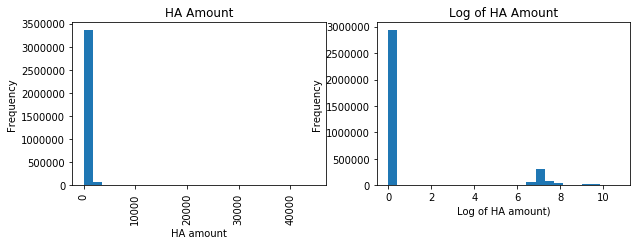

In [41]:
def plot_ha_amount(train=trainDf):
    '''Plots the distribution of HA Amount (dependent variable).
    Accepts dataframe as input.  Displays distribution of HA
    Amount (untransformed) and transformed logarithmically.
    '''
    # Define figure
    fig, axes = plt.subplots(1,2, figsize = (10,3))

    # Histogram of sale price
    axes[0].hist(train.haAmount, bins=25)
    axes[0].set_title('HA Amount')
    axes[0].set_xlabel('HA amount')
    axes[0].set_ylabel('Frequency')

    # Rotate x labels
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

    # Histogram of log(sale price) 
    axes[1].hist(np.log1p(train.haAmount), bins=25)
    axes[1].set_title('Log of HA Amount')
    axes[1].set_xlabel('Log of HA amount)')
    axes[1].set_ylabel('Frequency')

plot_ha_amount()

## Modeling

In [4]:
# Load FL/TX data
df = pd.read_csv("../data/open-fema/FEMA-Large-Demographics-FL-TX.csv")

In [5]:
def adaboost_regressor(full_data=df):
    
    # Split the data into train and test data
    X = full_data.loc[:, full_data.columns != 'haAmount']
    y = full_data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # AdaBoost - fit the model
    ada = AdaBoostRegressor(random_state=0, n_estimators=100)
    ada.fit(X_train, y_train)

    # Predict
    y_pred = ada.predict(X_test)
    
    # Parameters and results
    print('AdaBoost Regressor')
    print('Features: {}'.format(X_train.shape[1]))
    print('R^2: {:.4f}'.format(ada.score(X_train, y_train)))
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    return(ada)

### FEMA Only

In [6]:
def transform_fema(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.
    '''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [7]:
# Transform
df_fema = transform_fema(df)

# AdaBoost with Fema only
ada = adaboost_regressor(df_fema)

# Save the model
pickle.dump(ada, open('ada-boost.sav', 'wb'))

AdaBoost Regressor
Features: 34
R^2: 0.5149
MAE: 422.14
MSE: 3091737.52
RMSE: 1758.33


In [10]:
# Load saved model
ada = pickle.load(open('ada-boost.sav', 'rb'))

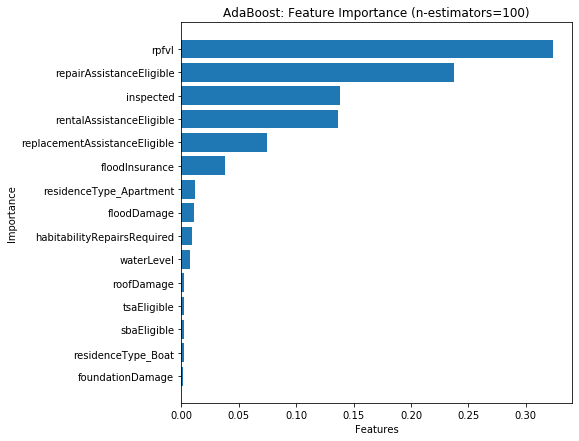

In [11]:
def plot_importance(model, data):

    # Feature importance
    df_trim = df_fema.loc[:, df_fema.columns != 'haAmount']
    importance = pd.DataFrame({'feature': df_trim.columns, 'importance': ada.feature_importances_})
    importance.sort_values(by='importance', ascending=True, inplace=True)
    trimmed_features = importance.loc[importance['importance'] > 0.001]
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize = (7,7))
    ax.barh(trimmed_features['feature'], trimmed_features['importance'])
    ax.set_title('AdaBoost: Feature Importance (n-estimators={})'.format(ada.get_params()['n_estimators']))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    
    # Sort descending
    importance.sort_values(by='importance', ascending=False, inplace=True)
    
    return(importance)
    
ada_features = plot_importance(model=ada, data=df_fema)

### Top Feature by Importance

In [12]:
def transform_fema_top(data, top_n):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Top n features (with haAmount added)
    backsub_cols = ada_features['feature'].to_numpy()[0:top_n]
    print('Top {} features: \n{}\n'.format(top_n, backsub_cols))
    
    # Select columns (with haAmount added)
    backsub_cols = np.append(backsub_cols, 'haAmount')
    data = data.loc[:, backsub_cols]
    
    return(data)

In [13]:
# Transform with backward substitution
df_fema_top = transform_fema_back(data=df, top_n=7)

# AdaBoost with fema only
ada_top = adaboost_regressor(df_fema_top)

# Save the model
pickle.dump(ada, open('ada-top.sav', 'wb'))

Top 7 features: 
['rpfvl' 'repairAssistanceEligible' 'inspected' 'rentalAssistanceEligible'
 'replacementAssistanceEligible' 'floodInsurance'
 'residenceType_Apartment']

AdaBoost Regressor
Features: 7
R^2: 0.5135
MAE: 429.50
MSE: 3090010.92
RMSE: 1757.84


In [14]:
# Load saved model
ada_top = pickle.load(open('ada-top.sav', 'rb'))

### Forward Sequential Feature Selector

In [15]:
# Transform
df_fema = transform_fema(df)

# Split the data into train and test data
X = df_fema.loc[:, df_fema.columns != 'haAmount'].head(1000)
y = df_fema.loc[:, 'haAmount'].head(1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 34) (800,)
(200, 34) (200,)


In [24]:
# Load saved model
ada = pickle.load(open('ada-boost.sav', 'rb'))

# AdaBoost fitted with feature selector
sfs = SequentialFeatureSelector(ada, direction='forward', n_features_to_select=7)
sfs.fit(X_train, y_train)

print('Forward sequential selection: \n{}'.format(X_train.columns[sfs.get_support()]))

Forward sequential selection: 
Index(['floodInsurance', 'inspected', 'rpfvl', 'destroyed', 'floodDamage',
       'rentalAssistanceEligible', 'repairAssistanceEligible'],
      dtype='object')


In [28]:
def forward_selector(data):
    
    # Define columns
    cols = ['floodInsurance', 'inspected', 'rpfvl', 'destroyed', 'floodDamage',
            'rentalAssistanceEligible', 'repairAssistanceEligible', 'haAmount']
    
    # Select columns
    data = data.loc[:, cols]
    return(data)

In [29]:
# Transform
df_fema_forward = forward_selector(df)

# AdaBoost with Fema only
ada_forward = adaboost_regressor(df_fema_forward)

# Save the model
pickle.dump(ada, open('ada-forward.sav', 'wb'))

AdaBoost Regressor
Features: 7
R^2: 0.7667
MAE: 288.88
MSE: 1482487.08
RMSE: 1217.57


In [30]:
# Load saved model
ada_forward = pickle.load(open('ada-forward.sav', 'rb'))

### Backward Sequential Feature Selector

In [31]:
# Load saved model
ada = pickle.load(open('ada-boost.sav', 'rb'))

# AdaBoost fitted with feature selector
sfs = SequentialFeatureSelector(ada, direction='backward', n_features_to_select=7)
sfs.fit(X_train, y_train)

print('Backward sequential selection: \n{}'.format(X_train.columns[sfs.get_support()]))

Backward sequential selection: 
Index(['floodInsurance', 'inspected', 'rpfvl', 'floodDamage',
       'rentalAssistanceEligible', 'repairAssistanceEligible',
       'residenceType_Mobile Home'],
      dtype='object')


In [33]:
def backward_selector(data):
    
    # Define columns
    cols = ['floodInsurance', 'inspected', 'rpfvl', 'floodDamage', 'rentalAssistanceEligible',
            'repairAssistanceEligible', 'residenceType_Mobile Home', 'haAmount']
    
    # Select columns
    data = data.loc[:, cols]
    return(data)

In [34]:
# Transform
df_fema_backward = backward_selector(df)

# AdaBoost with Fema only
ada_backward = adaboost_regressor(df_fema_backward)

# Save the model
pickle.dump(ada, open('ada-backward.sav', 'wb'))

AdaBoost Regressor
Features: 7
R^2: 0.7666
MAE: 289.75
MSE: 1486714.70
RMSE: 1219.31


In [ ]:
# Load saved model
ada_backward = pickle.load(open('ada-backward.sav', 'rb'))

### FEMA Only with Grid Search

In [ ]:
def adaboost_optimizer(full_data=df):
    '''Fit GridSearchCV using AdaBoost regression for various
    parameters. Accepts input of full_data and returns (prints)
    the best model score and corresponding parameters.
    '''
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = full_data.loc[:, full_data.columns != 'haAmount']
    y = full_data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=7)

    # Parameters
    model = AdaBoostRegressor(random_state=0)
    param_grid = {'n_estimators': np.array([50, 100, 125, 150, 200]),
                  'learning_rate': np.array([0.01, 0.2, 0.5, 0.8, 1]),
                  'loss': ['linear', 'square', 'exponential']}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Make predictions
    y_pred = grid_search.predict(X_test)

    # summarize the results of the grid search
    print('AdaBoost Regressor')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.n_estimators))
    print('Best learning rate: {:.2f}'.format(grid_search.best_estimator_.learning_rate))
    print('Best loss: {}'.format(grid_search.best_estimator_.loss))
    
    print('\nTime (seconds): {:.0f} '.format(time.time() - start_time))
    print('Time (minutes): {:.1f}'.format((time.time() - start_time)/60))

adaboost_optimizer(df_fema)

### FEMA with Basic Demographics 

In [180]:
def transform_fema_plus(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown', 'built_1979_or_earlier_rate']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [181]:
# Transform
df_fema_plus = transform_fema_plus(df)

# AdaBoost with basic demographics
ada_plus = adaboost_regressor(df_fema_plus)

AdaBoost Regressor
Features: 36
R^2: 0.5510
MAE: 404.95
MSE: 2843580.93
RMSE: 1686.29


In [112]:
def transform_demo_basic(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown', 'below_poverty_rate', 'median_earnings_total',
            'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [113]:
# Transform
df_demo = transform_demo_basic(df)

# AdaBoost with basic demographics
ada_demo = adaboost_regressor(df_demo)

AdaBoost Regressor
Features: 40
R^2: 0.5758
MAE: 398.35
MSE: 2697547.24
RMSE: 1642.42


In [146]:
# Plot importance
#plot_importance(model=ada_demo, data=df_demo)

### FEMA with DVI

In [116]:
def transform_demo_dvi(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown', 'dvi']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [117]:
# Transform
df_dvi = transform_demo_dvi(df)

# AdaBoost with basic demographics
ada_dvi = adaboost_regressor(transform_demo_dvi(df))

AdaBoost Regressor
Features: 36
R^2: 0.6246
MAE: 364.50
MSE: 2374171.35
RMSE: 1540.83


In [147]:
# Plot importance
#plot_importance(model=ada_dvi, data=df_dvi)

## Scrap Code

In [ ]:
## Full Data - Dmensionality Reduction

# Check vars in index
#print(df.columns)

# Check for NaNs
#trainDf.isna().any()

In [182]:
# Save the model
#pickle.dump(model_rf_best, open('random_forest.sav', 'wb'))


In [183]:
# Load saved model
#model_rf_sav = pickle.load(open('random_forest.sav', 'rb'))
#y_pred_sav = model_rf_sav.predict(X_test)
#print('Total HA Amount predicted: ${:,.2f}'.format(y_pred_sav.sum()))
#print('Total HA Amount actual: ${:,.2f}'.format(y_test.sum()))